# Modulos en Julia (librerias)

Para mayor información consulten la documentación: https://docs.julialang.org/en/v1/manual/documentation/

In [2]:
__precompile__() # Este comando es para que julia precompile el paquete

module herramientas

export original_integer, base_2

@doc "original integer input: list of binary digits output: integer"
function original_integer(list)
    return parse(Int, join(list); base=2)
end

@doc "base_2 input: integer and pad optional output: list of binary digits"
function base_2(integer; pad= nothing)
    if pad == nothing
        return reverse(digits(integer, base = 2))
    else
        return reverse(digits(integer, base = 2, pad = pad))
    end
end

end

Main.herramientas

Accediendo a la documentación:

In [3]:
@doc herramientas.base_2

base_2 input: integer and pad optional output: list of binary digits


In [4]:
@doc herramientas.original_integer

original integer input: list of binary digits output: integer


Al evaluar la celda donde está el módulo, de acuerdo a la documentación, estamos obteniendo el comportamiento de `import`

In [5]:
include("herramientas.jl")
import .herramientas

In [6]:
herramientas.base_2

base_2 (generic function with 1 method)

Para ver como funciona `using` debemos hacer la libreria propiamente en su propio archivo.

In [7]:
include("herramientas.jl") # Necesario para hacerle saber a Julia que el archivo existe. Hay formas de automatizar esto.
using .herramientas

In [8]:
@doc custom_unique

custom_unique input: list output: list with unique elements. This function aims to correct the behavior of unique that selects -0.0 and 0.0 as different numbers


In [9]:
custom_unique([1,1,0])

2-element Vector{Any}:
 1
 0

In [10]:
@doc original_integer

original integer input: list of binary digits output: integer


In [11]:
@show is_approx_equal

UndefVarError: UndefVarError: `is_approx_equal` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [12]:
@show herramientas.is_approx_equal

herramientas.is_approx_equal = Main.herramientas.is_approx_equal


is_approx_equal (generic function with 1 method)

Cabe señalar que `import` deja el _workspace_ limpio, ya que lo que hace es importar solo hace disponible el modulo

## Hacer disponibles las librerias desde cualquier lugar.

Para hacer disponibles sus librerias desde cualquier lugar de la máquina usando ``using``, basta con añadir en la carpeta de configuración de Julia (en Linux ``~/.julia/config/) el archivo ``startup.jl``. Si la carpeta no existe, la pueden crear. Dentro de ``startup.jl`` hay que poner una linea para agregar la carpeta donde se encuentran sus módulos a ``LOAD_PATH``, por ejemplo: ``push!(LOAD_PATH,"/home/david/libs/julia/")``

# Uso de tipos

A continuación vemos un uso común de los tipos, en los que creamos rutinas eficientes para cada tipo sobrecargando el mismo nombre. Dependiendo del tipo, Julia usa una u otra rutina.

In [13]:
function ejemplito(x::Int)
    print("$x is an integer")
end

function ejemplito(x::AbstractFloat)
    print("$x is an float")
end

ejemplito (generic function with 2 methods)

In [14]:
ejemplito(1)

1 is an integer

In [15]:
ejemplito(1.0)

1.0 is an float

También es posible especificar el tipo de salida

In [16]:
function sum_two_vectors(a::Vector{ComplexF64}, b::Vector{ComplexF64}):: Vector{ComplexF64}
        if length(a) != length(b)
        throw(ArgumentError("Vectors must be of the same length"))
    end
    return a + b
end

sum_two_vectors (generic function with 1 method)

In [17]:
[1.0 + 1.0im ,2,3]

3-element Vector{ComplexF64}:
 1.0 + 1.0im
 2.0 + 0.0im
 3.0 + 0.0im

In [18]:
sum_two_vectors([1.0 + 0.0im ,2,3], [4.0,5,6+0.0im])

3-element Vector{ComplexF64}:
 5.0 + 0.0im
 7.0 + 0.0im
 9.0 + 0.0im

Sin embargo, como vimos en clase, observese lo siguiente:

In [19]:
sum_two_vectors([1.0 ,2,3], [4.0,5,6])

MethodError: MethodError: no method matching sum_two_vectors(::Vector{Float64}, ::Vector{Float64})
The function `sum_two_vectors` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  sum_two_vectors(!Matched::Vector{ComplexF64}, !Matched::Vector{ComplexF64})
   @ Main ~/Escritorio/Maestria/Proyectos/clases/metodos_sim_num/clases/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X34sZmlsZQ==.jl:1


__Nota:__ Incluso usando flotantes, si no son explicitamente complejos, el método falla. En clase vimos como hacer una función que reciba vectores donde las entradas son de cualquier tipo. Esto es útil si solo nos interesa diferenciar entre vectores y matrices

In [20]:
function sum_two_vectors(a::Vector{T}, b::Vector{T})::Vector{T} where T
    if length(a) != length(b)
        throw(ArgumentError("Vectors must be of the same length"))
    end
    return a + b
end

sum_two_vectors (generic function with 2 methods)

Entonces ya funciona con cualquier tipo:

In [21]:
sum_two_vectors([1,2,3], [4,5,6])

3-element Vector{Int64}:
 5
 7
 9

# Paralelización

## Vectorización

A lo largo del curso ya utilizamos vectorización como método para hacer muchas operaciones eficientemente, con el operador ``broadcasting``, por ejemplos ``arreglo^.2``, donde dejamos que Julia maneje de forma eficiente las operaciones sobre el arreglo.

## Usando más de un hilo (Multi-Threads)

Por defecto Julia usa un hilo.

In [3]:
Threads.nthreads()

1

Pero podemos cambiar la configuración de vs code para aumentar el número

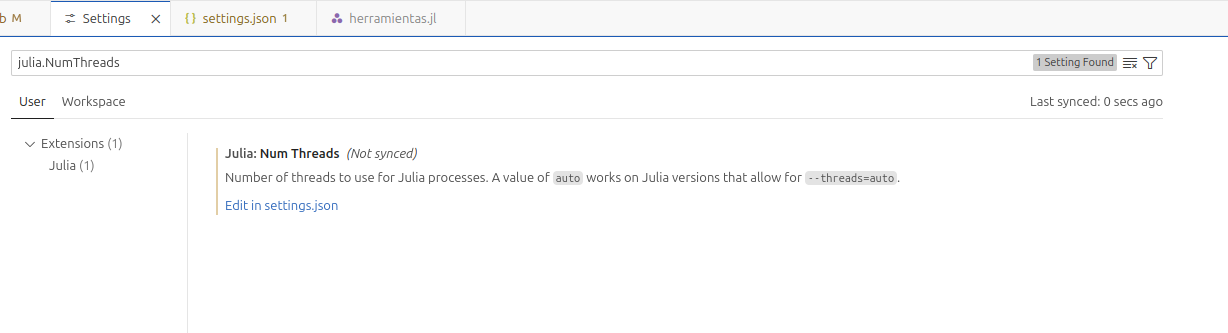

In [1]:
Threads.nthreads()

4

In [2]:
a = zeros(10)
Threads.@threads for i = 1:10
    a[i] = Threads.threadid()
end
a

10-element Vector{Float64}:
 4.0
 4.0
 4.0
 3.0
 3.0
 3.0
 2.0
 2.0
 1.0
 1.0

In [4]:
function sum_single(a)
        s = 0
        for i in a
            s += i
        end
        s
end

sum_single(1:1_000_000)

500000500000

In [5]:
function sum_multi_bad(a)
           s = 0
           Threads.@threads for i in a
               s += i
           end
           s
       end

sum_multi_bad(1:1_000_000) # Sufre de "data race"

220921992378

In [21]:
chunks = Iterators.partition(a, length(a) ÷ Threads.nthreads())

Base.Iterators.PartitionIterator{Vector{Float64}}([4.0, 4.0, 4.0, 3.0, 3.0, 3.0, 2.0, 2.0, 1.0, 1.0], 2)

In [23]:
a

10-element Vector{Float64}:
 4.0
 4.0
 4.0
 3.0
 3.0
 3.0
 2.0
 2.0
 1.0
 1.0

In [22]:
for i in chunks
    print(i)
end

[4.0, 4.0][4.0, 3.0][3.0, 3.0][2.0, 2.0][1.0, 1.0]

Antes de continuar, veamos nueva sintaxis:

In [10]:
result = map([1, 2, 3]) do x
    x^2
end
println(result)  # Output: [1, 4, 9]

[1, 4, 9]


Es equivalente a:

In [11]:
map(x->x^2, [1, 2, 3])|>print

[1, 4, 9]

Sin embargo la forma de arriba parece sufrir menos errores cuando la función tiene un decorador

In [61]:
sum = 0
    for i in 1:10
        sum += i
    end
sum

55

In [34]:
sum_single([2,3])

5

In [12]:
function sum_multi_good(a)
           chunks = Iterators.partition(a, length(a) ÷ Threads.nthreads())
           tasks = map(chunks) do chunk
               Threads.@spawn sum_single(chunk)
           end
           print(tasks)
           chunk_sums = fetch.(tasks)
           return sum_single(chunk_sums)
end

sum_multi_good(1:1_000_000)


Task[Task (runnable, started) @0x00007b3d43d40970, Task (done) @0x00007b3d43d40b00, Task (runnable, started) @0x00007b3d43d40c90, Task (done) @0x00007b3d43d40e20]

500000500000

In [2]:
using quantum

In [1]:
function apply_multiqubit_gate_multi_thread(state::Vector{T}, gate, target) where T
    new_state = copy(state)
    dim_target = size(gate)[1]
    dim_untouched = length(state) ÷ dim_target |> Int

    Threads.@threads for index_untouched in 0:dim_untouched-1
        pos = [merge_two_integers(index_target, index_untouched, target) + 1 for index_target in 0:dim_target-1]
        new_state[pos] = gate * new_state[pos]
    end

    return new_state
end

apply_multiqubit_gate_multi_thread (generic function with 1 method)

In [6]:
proc = Vector{Tuple{Number, Number}}(undef, 10)
Threads.@threads for i in 1:10
    #push!(proc,(Threads.threadid(), i^2))
    proc[i]=(Threads.threadid(), i^2)
end
proc

10-element Vector{Tuple{Number, Number}}:
 (2, 1)
 (2, 4)
 (2, 9)
 (4, 16)
 (4, 25)
 (4, 36)
 (3, 49)
 (3, 64)
 (1, 81)
 (1, 100)

In [5]:
state = random_state(16)
apply_multiqubit_gate_multi_thread(state, sigmas[1],1) - apply_multiqubit_gate(state, sigmas[1],1)

16-element Vector{ComplexF64}:
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

Favor de checar la documentación para ver como se usan los multi-threads: https://docs.julialang.org/en/v1/manual/multi-threading/#man-multithreading

## Usando muchos procesos (Multi-Processing)

In [2]:
using Distributed

In [8]:
nprocs() # numero de procesos

1

In [14]:
workers()

2-element Vector{Int64}:
 2
 3

In [15]:
# add workers
addprocs(2) # agregar 2 workers, cuidado, si lo vuelven a correr, se añaden otros dos
nprocs() # numero de procesos

5

In [16]:
workers()

4-element Vector{Int64}:
 2
 3
 4
 5

In [18]:
# remove all workers expect the main
rmprocs(workers()) # remove all workers expect the main
nprocs() # numero de procesos

┌ Warning: rmprocs: process 1 not removed
└ @ Distributed /home/david/.julia/juliaup/julia-1.11.5+0.x64.linux.gnu/share/julia/stdlib/v1.11/Distributed/src/cluster.jl:1049


1

In [22]:
rmprocs(workers())

Task (done) @0x000073af09f9a270

In [5]:
# add workers
rmprocs(workers())
addprocs(4) # agregar 4 workers, cuidado, si lo vuelven a correr, se añaden otros dos
nprocs() # numero de procesos

┌ Warning: rmprocs: process 1 not removed
└ @ Distributed /home/david/.julia/juliaup/julia-1.11.5+0.x64.linux.gnu/share/julia/stdlib/v1.11/Distributed/src/cluster.jl:1049


5

Loops utilizando varios procesos, se utilizan arreglos compartidos para permitir que varios procesos accedan al mismo vector.

In [8]:
@everywhere using SharedArrays

a = SharedArray{Float64}(10)
@distributed for i = 1:10
    a[i] = myid()
end

Task (runnable, started) @0x000074387a0d4c90

In [9]:
a

10-element SharedVector{Float64}:
 3.0
 3.0
 3.0
 4.0
 4.0
 4.0
 5.0
 5.0
 2.0
 2.0

También existe parallel map en Distributed:

In [10]:
using LinearAlgebra

In [12]:
M = Matrix{Float64}[rand(10,10) for i = 1:10];

singular_values = pmap(svdvals, M);

In [13]:
singular_values

10-element Vector{Vector{Float64}}:
 [5.371796088912782, 1.4902083071784837, 1.273632491388602, 1.1407768816455777, 1.0135294820156346, 0.8726740140879344, 0.4730254895770353, 0.3348051796024388, 0.2304967950241368, 0.1545105814525584]
 [5.289518643585148, 1.3688623415011456, 1.1497285229949106, 1.003912074710329, 0.8127688579215477, 0.6207684925700976, 0.5020155359480039, 0.3605286922526644, 0.2927835697752153, 0.23773818184784612]
 [5.629980593387088, 1.237237002498428, 1.1882763265729588, 1.0716807044921204, 0.8940932650200057, 0.6748881501176585, 0.5043640880392224, 0.3671252139514715, 0.1470648218806359, 0.07378129914857072]
 [5.590547386217717, 1.452711482053013, 1.2539405709883276, 1.121757679607183, 0.7251192913323378, 0.5619870677358195, 0.4114781118026853, 0.24086139413730798, 0.1105484043173538, 0.050951747147417764]
 [5.158182546598711, 1.4802309398667484, 1.2720539281799592, 1.0582306571750786, 0.8484814926836581, 0.7789160277182511, 0.5818008143469464, 0.5612826477162751,

Una de las diferencias entre ``Threads`` y ``Distributed`` es que el primero comparte la memoria y el segundo no. Además, los procesos se pueden distribuir entre máquinas, mientras que los hilos no.

Como definir el workspace para trabajar con multiples procesos?

In [14]:
@everywhere using quantum

O por bloques:

In [17]:
@everywhere begin
    using quantum
    using LinearAlgebra
    using SharedArrays
    function test_parallel(a)
        return a^2
    end
end

In [20]:
@sync @distributed for i in 1:10
    println("Worker $(myid()) is running")
    println(test_parallel(i))
end

      From worker 4:	Worker 4 is running
      From worker 4:	16
      From worker 4:	Worker 4 is running
      From worker 4:	25
      From worker 4:	Worker 4 is running
      From worker 4:	36
      From worker 3:	Worker 3 is running
      From worker 3:	1
      From worker 3:	Worker 3 is running
      From worker 3:	4
      From worker 3:	Worker 3 is running
      From worker 3:	9
      From worker 2:	Worker 2 is running
      From worker 2:	81
      From worker 2:	Worker 2 is running
      From worker 2:	100
      From worker 5:	Worker 5 is running
      From worker 5:	49
      From worker 5:	Worker 5 is running
      From worker 5:	64


Task (done) @0x000074387a90cc90

Ejemplo simple:

In [28]:
# Crear un arreglo compartido
a = SharedArray{Float64}(10)

@distributed for i = 1:10
    a[i] = i
end
a

10-element SharedVector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

El problema aquí es que el macro no espera a que todas las tareas terminen, esto se resuelve con el macro ``@sync``

In [29]:
# Crear un arreglo compartido
a = SharedArray{Float64}(10)

@sync @distributed for i = 1:10
    a[i] = i
end
a

10-element SharedVector{Float64}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0

In [30]:
a = SharedArray{Float64}(10)

# Usar pmap para asignar valores
pmap(i -> (a[i] = i), 1:10)

a

10-element SharedVector{Float64}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0

Distributed es bastante útil también cuando lidiamos con el problema de hacer el mismo proceso multiples veces. Por ejemplo, si queremos propagar muchos estados diferentes con la misma dinámica. En ese caso, de hecho conviene que cada proceso tenga su propia memoria.

Otro ejemplo, esta vez utilizando reductores

In [31]:
result = @distributed (+) for i in 1:100
    i
end

result

5050

In [33]:
result = @distributed (vcat) for i in 1:100
    (myid(), i)
end

result

100-element Vector{Tuple{Int64, Int64}}:
 (2, 1)
 (2, 2)
 (2, 3)
 (2, 4)
 (2, 5)
 (2, 6)
 (2, 7)
 (2, 8)
 (2, 9)
 (2, 10)
 ⋮
 (5, 92)
 (5, 93)
 (5, 94)
 (5, 95)
 (5, 96)
 (5, 97)
 (5, 98)
 (5, 99)
 (5, 100)

In [36]:
result = @distributed (vcat) for i in 1:100
    [myid(), [i, i+1]]
end

result

200-element Vector{Any}:
 2
  [1, 2]
 2
  [2, 3]
 2
  [3, 4]
 2
  [4, 5]
 2
  [5, 6]
 ⋮
  [96, 97]
 5
  [97, 98]
 5
  [98, 99]
 5
  [99, 100]
 5
  [100, 101]

In [118]:
workers()

8-element Vector{Int64}:
  4
  5
  6
  7
  8
  9
 10
 11

In [41]:
pmap(x->myid(), 1:10)

10-element Vector{Int64}:
 2
 3
 4
 5
 4
 5
 5
 5
 4
 4